# SGD Tests

This file creates a powerlaw-random features problem setup for testing in optax.  We compare against the ODE and the other SGD implementations.

In [124]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm

key = random.PRNGKey(0)

In [80]:
import matplotlib.pyplot as plt

In [141]:
class power_law_RF:
    """
    A class that generates power-law random features regression problems.

    This class creates synthetic regression problems with power-law decaying eigenvalues 
    and target coefficients. The features are generated by first sampling random Gaussian 
    features and then scaling them according to a power law.

    Attributes:
        alpha (float): Power law exponent for eigenvalue decay
        beta (float): Power law exponent for target coefficient decay  
        W (ndarray): Random features matrix of shape (v, d)
        v (int): Hidden dimensionality
        d (int): Embedded dimensionality
        x_grid (ndarray): Grid of indices from 1 to v, shape (1,v)
        population_eigenvalues (ndarray): Power-law decaying eigenvalues
        b (ndarray): Power-law decaying target coefficients
        population_trace (float): Sum of population eigenvalues
        checkW (ndarray): Scaled random features matrix
        checkb (ndarray): Scaled target coefficients
    """

    def __init__(self, alpha, beta, W):
        self.alpha = alpha
        self.beta = beta
        self.W = W
        self.v = self.W.shape[0]
        self.d = self.W.shape[1]
        self.x_grid=jnp.arange(1, self.v+1).reshape(1,self.v)
        self.population_eigenvalues = self.x_grid**(-self.alpha)
        self.b = self.x_grid.transpose()**(-beta)
        self.population_trace = jnp.sum(self.population_eigenvalues)
        self.checkW = W * self.population_eigenvalues.T
        self.checkb = self.x_grid.transpose()**(-alpha-beta)
        
    @classmethod
    def initialize_random(cls, alpha, beta, v, d, key):
        """
        Creates a new power_law_RF instance with randomly initialized features.

        Args:
            alpha (float): Power law exponent for eigenvalue decay
            beta (float): Power law exponent for target coefficient decay
            v (int): Hidden dimensionality
            d (int): Embedded dimensionality
            key (PRNGKey): JAX random number generator key

        Returns:
            power_law_RF: A new instance with randomly sampled features matrix W
                         scaled to have variance 1/d
        """
        # Sample random features matrix with variance 1/d
        W = random.normal(key, (v, d)) / jnp.sqrt(d)
        return cls(alpha=alpha, beta=beta, W=W)
    
    def get_population_risk(self, w):
        """
        Calculates the population risk for given weights.
        
        The population risk is the expected squared error over the data distribution.
        For power-law random features regression, this can be computed analytically
        without sampling data.
        
        Args:
            w (ndarray): Weight vector of shape (d,)
        
        Returns:
            float: Population risk value
        """
        # Project weights onto random features
        proj = jnp.matmul(self.checkW, w)
        
        # Calculate population risk using eigenvalues and target coefficients
        risk = jnp.sum((proj - self.checkb)**2)
        return risk / 2
    

    def get_data(self, key, batch):
        """
        Generates a batch of synthetic data points.
        
        Args:
            key (PRNGKey): JAX random number generator key
            batch (int): Number of data points to generate
            
        Returns:
            tuple: (X, y) where:
                X (ndarray): Input features of shape (batch, d)
                y (ndarray): Target values of shape (batch, 1)
        """
        # Generate random features
        x = random.normal(key, (batch, self.v))
        
        return jnp.matmul(x, self.checkW), jnp.matmul(x, self.checkb)
    
    def get_theory_limitloss(self):
        """Returns the theoretical limit of the loss (residual risk) for the current model parameters.
        
        Calculates the theoretical prediction for the residual risk level (risk at infinite time)
        using the model's alpha, beta, v (number of random features), and d (input dimension) parameters.
        
        Returns:
            float: Theoretical prediction for the residual risk level
        """
        return power_law_RF.theory_limitloss(self.alpha,self.beta,self.v,self.d)
    
    def theory_limitloss(alpha, beta,V,D):
        """Generate the 'exact' finite V, D expression the residual risk level (risk at time infinity)

        Parameters
        ----------
        alpha,beta : floats
            parameters of the model, ASSUMES V>D

        Returns
        -------
        theoretical prediction for the norm
        """
        cstar = 0.0
        if 2*alpha >= 1.0:
            kappa = power_law_RF.theory_kappa(alpha,V,D)
            cstar = jnp.sum( jnp.arange(1,V,1.0)**(-2.0*(beta+alpha))/( jnp.arange(1,V,1.0)**(-2.0*(alpha))*kappa*(D**(2*alpha)) + 1.0))

        if 2*alpha < 1.0:
            #tau = D/jnp.sum( jnp.arange(1,V,1.0)**(-2.0*alpha))
            tau = power_law_RF.theory_tau(alpha,V,D)
            cstar = jnp.sum( jnp.arange(1,V,1.0)**(-2.0*(beta+alpha))/( jnp.arange(1,V,1.0)**(-2.0*(alpha))*tau + 1.0))


        return cstar
    
    def theory_kappa(alpha, V,D):
        """Generate coefficient kappa with finite sample corrections.
        Parameters
        ----------
        alpha : float
            parameter of the model.
        V,D : integers
            parameters of the model.

        Returns
        -------
        theoretical prediction for kappa parameter
        """

        TMAX = 1000.0
        c, _ = sp.integrate.quad(lambda x: 1.0/(1.0+x**(2*alpha)),0.0,TMAX)
        kappa=c**(-2.0*alpha)

        kappa_it = lambda k : sp.integrate.quad(lambda x: 1.0/(k+x**(2*alpha)),0.0,V/D)[0]
        eps = 10E-4
        error = 1.0
        while error > eps:
            kappa1 = 1.0/kappa_it(kappa)
            error = abs(kappa1/kappa - 1.0)
            kappa = kappa1
        return kappa
    
    def theory_tau(alpha, V,D):
        """Generate coefficient tau with finite sample corrections.
        Parameters
        ----------
        alpha : float
            parameter of the model.
        V,D : integers
            parameters of the model.

        Returns
        -------
        theoretical prediction for kappa parameter
        """

        tau_it = lambda k : jnp.sum( 1.0/(D*(jnp.arange(1,V,1)**(2*alpha) +k)))
        tau = tau_it(0)
        eps = 10E-4
        error = 1.0
        while error > eps:
            tau1 = 1.0/tau_it(tau)
            error = abs(tau1/tau - 1.0)
            tau = tau1
        return tau
    
    def get_hessian_spectra(self):
        """Get eigenvalues of the Hessian matrix of the problem

        Returns
        -------
        ndarray
            Array containing the eigenvalues of the Hessian matrix, computed as 
            the squared singular values of the checkW matrix.
        """
        _, s, _ =jnp.linalg.svd(self.checkW,full_matrices=False)
        return s**2

    def get_rhos(self):
        """Get squared-projections of the residual (b) in the direction of the eigenmodes of the Hessian.

        Returns
        -------
        ndarray
            Array containing the squared-projections of the residual vector b onto the eigenvectors
            of the Hessian matrix, normalized by the corresponding eigenvalues.
        """
        Uvec, s, _ =jnp.linalg.svd(self.checkW,full_matrices=False)

        #Compute < ( D^1/2 W W^T D^(1/2) - z)^{-1}, D^(1/2) b >
        check_beta_weight = jnp.tensordot(self.checkb,Uvec,axes=[[0],[0]])[0]

        rhos = (check_beta_weight)**2 / s**2
        rhos.astype(jnp.float32)
        return rhos



In [129]:
def lsq_streaming_sgd_simple_noscan(
        key, 
        data_oracle,
        batch_size,
        steps,
        learning_rate,
        init,
        loss_oracle
):
    d=init.shape[0]
    tx = optax.sgd(learning_rate=learning_rate)
    params = init
    opt_state = tx.init(params)
    state = (params, opt_state)

    def batch_mse(params, embeddings, y):
        y_pred = embeddings@params
        return jnp.mean(optax.l2_loss(y_pred, y))

    def train_step(state,key):
        params, opt_state = state
        (embeddings, y) = data_oracle(key, batch_size)
        loss_fn = lambda params : batch_mse(params, embeddings, y)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    keyz = random.split(key, steps)
    losses=[]
    for i, key in enumerate(tqdm(keyz)):
        state, loss = train_step(state, key)
        pop_loss = loss_oracle(state[0])
        losses.append(pop_loss)

    return jnp.arange(1,steps+1), losses
    

In [130]:
def lsq_streaming_sgd_simple(
        key,
        data_oracle,
        batch_size,
        steps,
        learning_rate,
        init,
        loss_oracle
):
    """Trains a linear model using stochastic gradient descent with a simple learning rate schedule.
    
    Args:
        key: JAX PRNGKey for random number generation
        data_oracle: Function that generates batches of (embeddings, labels) training data
        batch_size: Number of samples per batch
        steps: Total number of optimization steps
        learning_rate: Fixed learning rate for SGD
        init: Initial parameter vector
        loss_oracle: Function that computes population loss given parameters
    
    Returns:
        tuple: (timestamps, losses) where timestamps are the iteration numbers at which
        losses were recorded and losses are the corresponding population loss values
    """
    tx = optax.sgd(learning_rate=learning_rate)
    params = init
    opt_state = tx.init(params)
    state = (params, opt_state)

    def batch_mse(params, embeddings, y):
        y_pred = embeddings@params
        return jnp.mean(optax.l2_loss(y_pred, y))

    def train_step(state,key):
        params, opt_state = state
        (embeddings, y) = data_oracle(key, batch_size)
        loss_fn = lambda params : batch_mse(params, embeddings, y)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        #return (params, opt_state), loss
        return (params, opt_state), None
    

    # This generates an exponentially spaced sequence of times at which we record the loss.
    # This is to ensure that we are recording the loss at a reasonable frequency.
    # We start at 0 and go up to the total number of steps.
    # We then add the number of steps to the list.
    # We then take the unique values and sort them.
    # This gives us the times at which we record the loss.
    
    losses=[]
    losstimes = jnp.unique(jnp.concatenate(
        [jnp.array([0]),
        jnp.int32(
            1.1**jnp.arange(1,jnp.ceil(jnp.log(steps)/jnp.log(1.1)))
        ),
        jnp.array([steps])]
    ))

    losstime_steps = losstimes[1:]-losstimes[:-1]
    losses.append(loss_oracle(init))
    for increment in tqdm(losstime_steps):
        key, subkey = random.split(key)
        keyz = random.split(subkey, increment)
        state, _ = jax.lax.scan(train_step, state, keyz)
        pop_loss = loss_oracle(state[0])
        losses.append(pop_loss)

    return losstimes, losses
    

In [139]:
def ode_resolvent_log_implicit_full(eigs_K, rho_init, chi_init, sigma_init, risk_infinity,
                  g1, g2, g3, delta, batch, D, t_max, Dt):
  """Generate the theoretical solution to momentum

  Parameters
  ----------
  eigs_K : array d
      eigenvalues of covariance matrix (W^TDW)
  rho_init : array d
    initial rho_j's (rho_j^2)
  chi_init : array (d)
      initialization of chi's
  sigma_init : array (d)
      initialization of sigma's (xi^2_j)
  risk_infinity : scalar
      represents the risk value at time infinity
  WtranD : array (v x d)
      WtranD where D = diag(j^(-2alpha)) and W is the random matrix
  alpha : float
      data complexity
  V : float
      vocabulary size
  g1, g2, g3 : function(time)
      learning rate functions
  delta : function(time)
      momentum function
  batch : int
      batch size
  D : int
      number of eigenvalues (i.e. shape of eigs_K)
  t_max : float
      The number of epochs
  Dt : float
      time step used in Euler

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  risks: numpy.array(float)
      the values of the risk

  """
  #times = jnp.arange(0, t_max, step = Dt, dtype= jnp.float64)
  times = jnp.arange(0, jnp.log(t_max), step = Dt, dtype= jnp.float32)

  risk_init = risk_infinity + jnp.sum(eigs_K * rho_init)

  def inverse_3x3(Omega):
      # Extract matrix elements
      a11, a12, a13 = Omega[0][0], Omega[0][1], Omega[0][2]
      a21, a22, a23 = Omega[1][0], Omega[1][1], Omega[1][2]
      a31, a32, a33 = Omega[2][0], Omega[2][1], Omega[2][2]

      # Calculate determinant
      det = (a11*a22*a33 + a12*a23*a31 + a13*a21*a32
            - a13*a22*a31 - a11*a23*a32 - a12*a21*a33)

      #if abs(det) < 1e-10:
      #    raise ValueError("Matrix is singular or nearly singular")

      # Calculate each element of inverse matrix
      inv = [[0,0,0],[0,0,0],[0,0,0]]

      inv[0][0] = (a22*a33 - a23*a32) / det
      inv[0][1] = (a13*a32 - a12*a33) / det
      inv[0][2] = (a12*a23 - a13*a22) / det

      inv[1][0] = (a23*a31 - a21*a33) / det
      inv[1][1] = (a11*a33 - a13*a31) / det
      inv[1][2] = (a13*a21 - a11*a23) / det

      inv[2][0] = (a21*a32 - a22*a31) / det
      inv[2][1] = (a12*a31 - a11*a32) / det
      inv[2][2] = (a11*a22 - a12*a21) / det

      return jnp.array(inv)

  def odeUpdate(stuff, time):
    v, risk = stuff
    timePlus = jnp.exp(time + Dt)

    Omega11 = -2.0 * batch * g2(timePlus) * eigs_K + batch * (batch + 1.0) * g2(timePlus)**2 * eigs_K**2
    Omega12 = g3(timePlus)**2 * jnp.ones_like(eigs_K)
    Omega13 = 2.0 * g3(timePlus) * (-1.0 + g2(timePlus) * batch * eigs_K)
    Omega1 = jnp.array([Omega11, Omega12, Omega13])

    Omega21 = batch * (batch + 1.0) * g1(timePlus)**2 * eigs_K**2
    Omega22 = ( -2.0 * delta(timePlus) + delta(timePlus)**2 ) * jnp.ones_like(eigs_K)
    Omega23 = 2.0 * g1(timePlus) * eigs_K * batch * ( 1.0 - delta(timePlus) )
    Omega2 = jnp.array([Omega21, Omega22, Omega23])

    Omega31 = g1(timePlus) * batch * eigs_K
    Omega32 = -g3(timePlus) * jnp.ones_like(eigs_K)
    Omega33 = -delta(timePlus) - g2(timePlus) * batch * eigs_K
    Omega3 = jnp.array([Omega31, Omega32, Omega33])

    Omega = jnp.array([Omega1, Omega2, Omega3]) #3 x 3 x d

    Identity = jnp.tensordot( jnp.eye(3), jnp.ones(D), 0 )

    A = inverse_3x3(Identity - (Dt * timePlus) * Omega) #3 x 3 x d

    Gamma = jnp.array([batch * g2(timePlus)**2, batch * g1(timePlus)**2, 0.0])
    z = jnp.einsum('i, j -> ij', jnp.array([1.0, 0.0, 0.0]), eigs_K)
    G_Lambda = jnp.einsum('i,j->ij', Gamma, eigs_K) #3 x d

    x_temp = v + Dt * timePlus * risk_infinity * G_Lambda
    x = jnp.einsum('ijk, jk -> ik', A, x_temp)

    y = jnp.einsum('ijk, jk -> ik', A, G_Lambda)

    vNew = x + ( Dt * timePlus * y * jnp.sum(x * z) / (1.0 - Dt * timePlus * jnp.sum(y * z)) )
    #vNew = vNew.at[0].set(jnp.maximum(vNew[0], 0.0))
    #vNew[0] = jnp.maximum(vNew[0], 10**(-7))
    #vNew[2] = jnp.maximum(vNew[2], 10**(-7))

    riskNew = risk_infinity + jnp.sum(eigs_K * vNew[0])
    return (vNew, riskNew), risk #(risk, vNew[0])

  _, risks = jax.lax.scan(odeUpdate,(jnp.array([rho_init,sigma_init, chi_init]),risk_init),times)
  return jnp.exp(times), risks/2

In [140]:
def jax_lsq_momentum1(key,
                g1, g2, g3, delta, batch, steps, init_x, init_w,
                t_oracle, loss, loss_times = jnp.array([0])
                ):
  """ This routine generates losses for SGD on the least squares
  problem with scalar targets, constant learning rate and constant batch size.

  Parameters
  ----------
  key : PRNGKey
    Jax PRNGKey
  g1, g2, g3 : function(time)
    The learning rate functions
  delta : function(time)
    The momentum function
  batch : int
    The batch-size to use
  steps : int
    The number of steps of minibatch SGD to generate
  init_x : vector
    The initial state for SGD to use
  init_w : vector
    The initial state for momentum
  traceK : float
    Trace of the covariance matrix of the data; i.e., K = E[aa^T]
  t_oracle: callable
    Takes as an argument a jax RNG key and a batch-size.
    Expects in return two tensors (A, y)
    of dimension (batch x data-dimension) and dimension (batch).
  loss: callable
    Takes as an argument a vector of length data-dimension,
    which is the current linear model parameters, and returns the
    loss.
  loss_times: vector
    Iteration counts at which to compute the loss

  Returns
  -------
  losses: vector
    An array of length 'steps' containing the losses
  loss_times: vector
    Iteration counts at which the losses were computed
  """

  if loss_times.shape[0]==1:
    loss_times = jnp.arange(steps)
  x = jnp.reshape(init_x,(len(init_x),1))
  w = jnp.reshape(init_w,(len(init_w),1))


  def update(z, things):
    keyz, iteration = things
    A,y = t_oracle(keyz, batch)
    x,w = z
    grad = jnp.tensordot(A,jnp.tensordot(A,x,axes=1)-y,axes=[[0],[0]])
    neww = (1.0 - delta(iteration)) * w + g1(iteration) * grad
    newx = x - g2(iteration) * grad - neww * g3(iteration)
    return (newx,neww), x

  keys=jax.random.split(key,steps)
  iters =  jnp.linspace(0.0, steps, num = steps)


 # update_jit = jax.jit(update)
  _, states = jax.lax.scan(update,(x,w),(keys,iters))

  return jax.lax.map(loss, states[loss_times[loss_times< steps]]), loss_times[loss_times< steps], states[-1]

First initialize the power law random features problem.

In [131]:
key, subkey = random.split(key)
problem = power_law_RF.initialize_random(alpha=1.0, beta=0.7, v=2000, d=500, key=subkey)



# Section  SGD unit test

This runs the training loop for 10**6 steps.

In [116]:
key, newkey = random.split(key)
times,losses = lsq_streaming_sgd_simple(newkey, 
                         problem.get_data, 
                         1, 
                         10**6, 
                         0.5/problem.population_trace, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Plot the results.

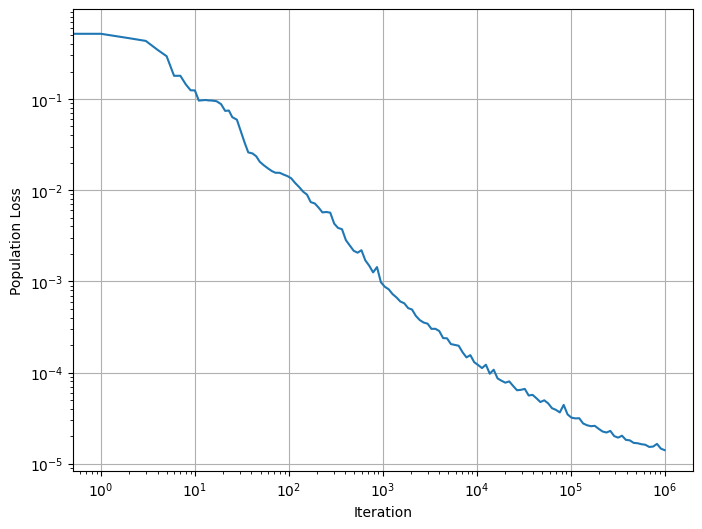

In [117]:
plt.figure(figsize=(8,6))
plt.loglog(times, losses)
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.show()


Compare new optax-based loop against previous JAX code

In [122]:
#Code for running pure SGD
sgd_gamma_2_constant = 0.5
sgd_gamma_2_scaling = sgd_gamma_2_constant / problem.population_trace
def g2_sgd(time):
  return sgd_gamma_2_scaling * jnp.ones_like(time)
def g1_sgd(time):
  return 0.0
def g3_sgd(time):
  return 0.0
def delta_sgd(time):
  return 0.0

key,nkey = jax.random.split(key)

losses_sgd, times_sgd, theta_final = jax_lsq_momentum1(nkey,
                g1_sgd, g2_sgd, g3_sgd, delta_sgd, 1, 10**5, 
                jnp.zeros(problem.d),jnp.zeros(problem.d),
                problem.get_data,problem.get_population_risk
                )

print('Initial loss value is {}'.format( losses_sgd[0]))

Initial loss value is 0.5693318843841553


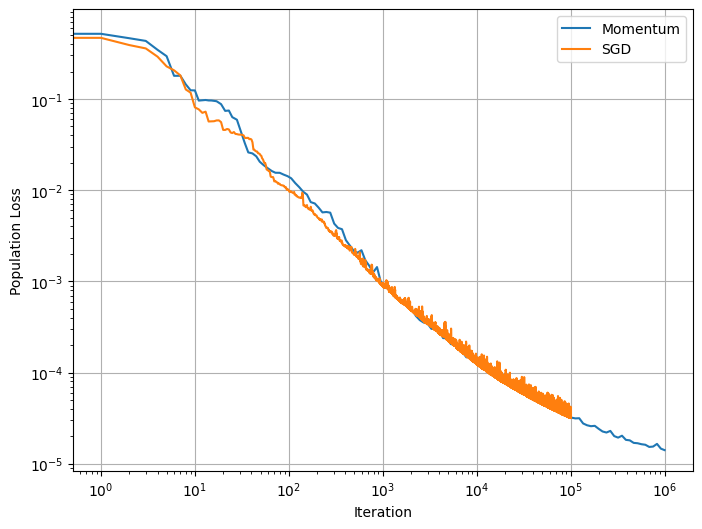

In [123]:
plt.figure(figsize=(8,6))
plt.loglog(times, losses, label='Momentum')
plt.loglog(times_sgd, losses_sgd, label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Code for running pure SGD
sgd_gamma_2_constant = 0.5
sgd_gamma_2_scaling = sgd_gamma_2_constant * jnp.minimum( 1.0 / jnp.float32(sgd_batch), 1.0 / traceK )
def g2_sgd(time):
  return sgd_gamma_2_scaling * jnp.ones_like(time)
def g1_sgd(time):
  return 0.0
def g3_sgd(time):
  return 0.0
def delta_sgd(time):
  return 0.0

key,nkey = jax.random.split(key)

losses_sgd, times_sgd, theta_final = jax_lsq_momentum1_opt2(nkey,
                g1_sgd, g2_sgd, g3_sgd, delta_sgd, sgd_batch, sgd_steps, jnp.zeros(D),jnp.zeros(D),
                ab_oracle,square_loss
                )

print('Initial loss value is {}'.format( losses_sgd[0]))

Compare against the ODE solution

In [ ]:
rho_init = problem.get_rhos()
sigma_init = jnp.zeros(problem.d, dtype=jnp.float32)
chi_init = jnp.zeros(problem.d, dtype=jnp.float32)

riskInftyTheory = problem.get_theory_limitloss()

print('Theoretical limiting loss value is {}'.format(riskInftyTheory))
K_eigs = problem.get_hessian_spectra()

print('Initial loss value is {}'.format( jnp.sum(rho_init * K_eigs) + riskInftyTheory))

Dt = 10**(-2)

odeTimes_sgd_1, odeRisks_sgd_1 = ode_resolvent_log_implicit_full(
    K_eigs.astype(jnp.float32), 
    rho_init, chi_init, sigma_init, riskInftyTheory,
    g1_sgd, g2_sgd, g3_sgd, delta_sgd, 
    1, problem.d, 10**5, Dt)


Theoretical limiting loss value is 2.2151913071866147e-05
Initial loss value is 1.1386654376983643


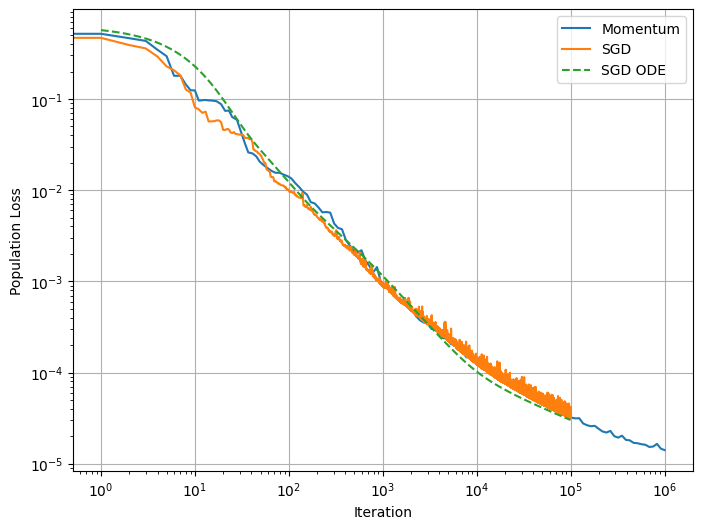

In [138]:
plt.figure(figsize=(8,6))
plt.loglog(times, losses, label='Momentum')
plt.loglog(times_sgd, losses_sgd, label='SGD')
plt.loglog(odeTimes_sgd_1, odeRisks_sgd_1, '--', label='SGD ODE')
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.legend()
plt.show()

#  DANA unit tests

In [142]:
#Code for running dana with decaying gamma 3 learning rate
dana_gamma_3_constant_decay = 0.1
dana_gamma_3_scaling_decay =  dana_gamma_3_constant_decay
dana_gamma_2_scaling_decay = 0.5 / problem.population_trace 
dana_gamma_1_scaling_decay = 1.0
dana_expMomentum_decay = 1.0

delta_constant = jnp.maximum(2.0  + ( 2.0 * problem.beta - 1 ) / (problem.alpha ), 2.0 - 1.0 / problem.alpha) + 1.0 #Need to be bigger than 2 + (2 * beta - 1) / (2 * alpha)


def g2_dana_decay(time):
  return dana_gamma_2_scaling_decay * jnp.ones_like(time)

def g1_dana_decay(time):
  return dana_gamma_1_scaling_decay * jnp.ones_like(time)

def g3_dana_decay(time):
  return dana_gamma_3_scaling_decay / (1.0 + time)**( 1.0 / (2.0 * problem.alpha) ) * 1.0 / problem.population_trace

def delta_dana_decay(time):
  return delta_constant / ( (1.0 + time)**dana_expMomentum_decay ) * jnp.ones_like(time)

key,nkey = jax.random.split(key)

losses_DANA_decay,times_DANA_decay, theta_final_DANA_decay = jax_lsq_momentum1(nkey,
                g1_dana_decay, g2_dana_decay, g3_dana_decay, delta_dana_decay, 
                1, 10**5, jnp.zeros(problem.d),jnp.zeros(problem.d),
                problem.get_data,problem.get_population_risk
                )

print('Initial loss value is {}'.format( losses_DANA_decay[0]))

Initial loss value is 0.5693318843841553


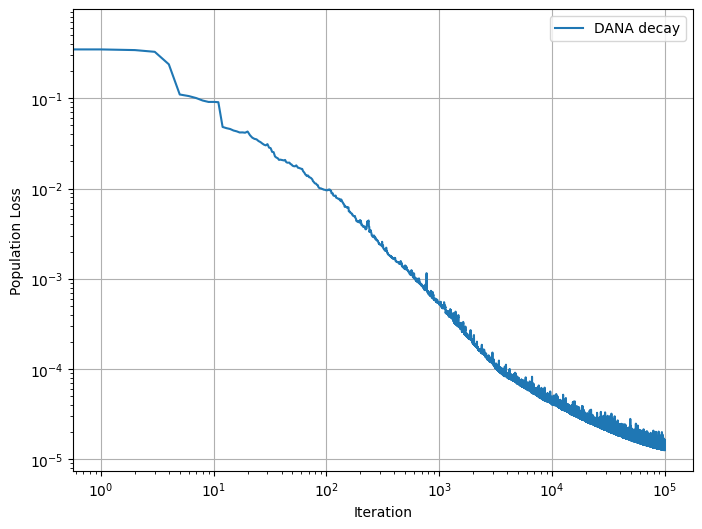

In [146]:
plt.figure(figsize=(8,6))
plt.loglog(times_DANA_decay, losses_DANA_decay, label='DANA decay')
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.legend()
plt.show()


In [147]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limitloss()

Dt = 10**(-2)

#check_b = jnp.ravel(theta_final)

odeTimes_dana_decay, odeRisks_dana_decay = ode_resolvent_log_implicit_full(
    Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory,
    g1_dana_decay, g2_dana_decay, g3_dana_decay, delta_dana_decay, 
    1, problem.d, 10**5, Dt)

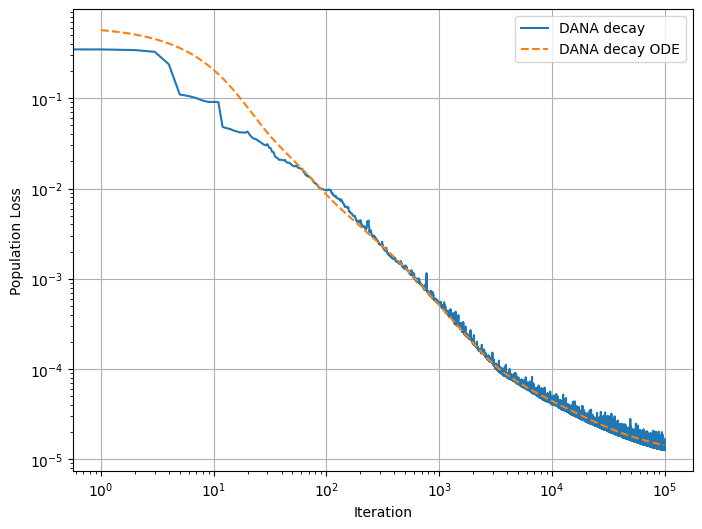

In [148]:
plt.figure(figsize=(8,6))
plt.loglog(times_DANA_decay, losses_DANA_decay, label='DANA decay')
plt.loglog(odeTimes_dana_decay, odeRisks_dana_decay, '--', label='DANA decay ODE')
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.legend()
plt.show()

Implement power-law schedule

In [150]:
import chex
from optax._src import base



In [160]:
def powerlaw_schedule(
    init_value: chex.Scalar,
    saturation_value: chex.Scalar,
    power: chex.Scalar,
    time_scale: int,
) -> base.Schedule:
  """Constructs power-law schedule.

  This function decays (or grows) the learning rate, until it is below
  the saturation_value, at which time it is held. The formula is given by
  :math:`max{ I*(1+t / time_scale) ^ {power}, saturation_value}`

  where :math:`I` is the initial value, :math:`t` is the current iteration, 
   :math:`time_scale` is the time scale of the power law, 
   :math:`power` is the power, and :math:`saturation_value` is the value
   at which the power law is saturated.

  Args:
    init_value: initial value for the scalar to be annealed.
    saturation_value: end value of the scalar to be annealed.
    power: the power of the power law.
    time_scale: number of steps over which the power law takes place.
      The scalar starts changing at ``transition_begin`` steps and completes
      the transition by ``transition_begin + transition_steps`` steps.
      If ``transition_steps <= 0``, then the entire annealing process is
      disabled and the value is held fixed at ``init_value``.
    transition_begin: must be positive. After how many steps to start annealing
      (before this many steps the scalar value is held fixed at ``init_value``).

  Returns:
    schedule
      A function that maps step counts to values.

  Examples:
    >>> schedule_fn = optax.powerlaw_schedule(
    ...    init_value=1.0, saturation_value=0.01, time_scale=100, power=2)
    >>> schedule_fn(0)  # learning rate on the first iteration
    Array(1., dtype=float32, weak_type=True)
    >>> schedule_fn(100)  # learning rate on the last iteration
    Array(0.01, dtype=float32, weak_type=True)
  """

  def schedule(count):
    frac = 1 + count / time_scale
    return jnp.maximum((init_value) * (frac**power),saturation_value)

  return schedule


In [164]:
from typing import NamedTuple, Optional, Union
from optax import tree_utils as otu
from optax._src import base
from optax._src import numerics
from optax._src import utils
from optax.transforms import _accumulation
from optax.transforms import _adding
import chex

In [201]:
class DanaOptimizerState(NamedTuple):
  """State for the Dana algorithm."""
  count: chex.Array  # shape=(), dtype=jnp.int32.
  y: base.Updates

def dana_optimizer(
    g1: base.ScalarOrSchedule,
    g2: base.ScalarOrSchedule,
    g3: base.ScalarOrSchedule,
    Delta: base.ScalarOrSchedule,
    y_dtype: Optional[chex.ArrayDType] = None,
    *,
    nesterov: bool = False,
    ) -> base.GradientTransformation:
    """Rescale updates according to the Adam algorithm.

    See :func:`optax.adam` for more details.

    Args:
        b1: Decay rate for the exponentially weighted average of grads.
        b2: Decay rate for the exponentially weighted average of squared grads.
        eps: Term added to the denominator to improve numerical stability.
        eps_root: Term added to the denominator inside the square-root to improve
        numerical stability when backpropagating gradients through the rescaling.
        mu_dtype: Optional `dtype` to be used for the first order accumulator; if
        `None` then the `dtype` is inferred from `params` and `updates`.
        nesterov: Whether to use Nesterov momentum. The variant of Adam with
        Nesterov momentum is described in [Dozat 2016]

    Returns:
        A :class:`optax.GradientTransformation` object.
    """

    y_dtype = utils.canonicalize_dtype(y_dtype)

    def init_fn(params):
        y = otu.tree_zeros_like(params, dtype=y_dtype)  # Momentum
        return DanaOptimizerState(count=jnp.zeros([], jnp.int32), y=y)

    def update_fn(updates, state, params=None):
        del params
        newDelta = Delta(state.count)
        newg1 = g1(state.count)
        newg2 = g2(state.count)
        newg3 = g3(state.count)

        y = jax.tree.map(
            lambda m,u : None if m is None else m*(1-newDelta) + newg1*u,
            state.y,
            updates,
            is_leaf=lambda x: x is None,
        )
        updates = jax.tree.map(
            lambda m,u : newg2*u if m is None else -1.0*(newg2*u + newg3*m),
            y,
            updates,
            is_leaf=lambda x: x is None,
        )
        y = otu.tree_cast(y, y_dtype)
        count_inc = numerics.safe_increment(state.count)

        return updates, DanaOptimizerState(count=count_inc, y=y)

    return base.GradientTransformation(init_fn, update_fn)

In [159]:
pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
plstimes,plslosses = lsq_streaming_sgd_simple(newkey, 
                         problem.get_data, 
                         1, 
                         10**6, 
                         pls, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

Array(2., dtype=float32, weak_type=True)

In [193]:
g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = powerlaw_schedule(0.0, 0.0, 0.0, 1)
Delta = powerlaw_schedule(1.0, 0.0, 0.0, 1)
danaopt = dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danatimes,danalosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         1, 
                         10**5, 
                         danaopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 106/106 [00:11<00:00,  9.08it/s]


In [204]:
g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = powerlaw_schedule(0.1/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         1, 
                         10**6, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:11<00:00,  1.82it/s]


In [174]:
pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
optimizer = optax.sgd(learning_rate=pls)

key, newkey = random.split(key)
plstimes,plslosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         1, 
                         10**5, 
                         optimizer, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:11<00:00,  9.60it/s]


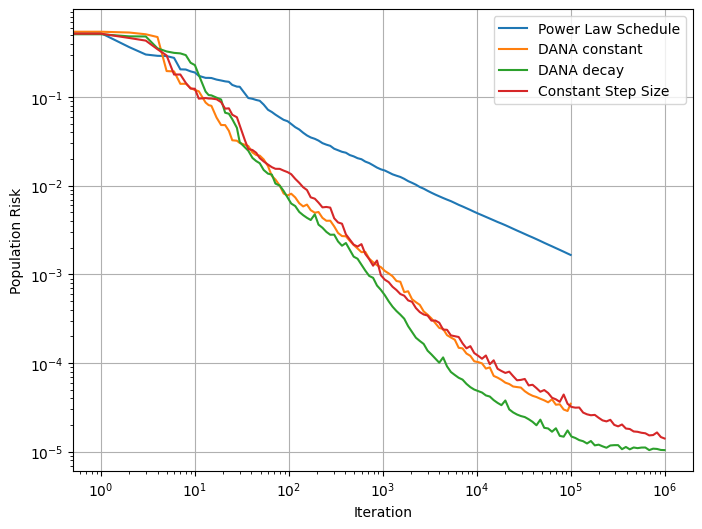

In [205]:
plt.figure(figsize=(8,6))
plt.loglog(plstimes, plslosses, label='Power Law Schedule')
plt.loglog(danatimes, danalosses, label='DANA constant')
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(times, losses, label='Constant Step Size')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)


In [206]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limitloss()

Dt = 10**(-2)

#check_b = jnp.ravel(theta_final)

odeTimes_dana_decay2, odeRisks_dana_decay2 = ode_resolvent_log_implicit_full(
    Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory,
    g1, g2, g3, Delta, 
    1, problem.d, 10**6, Dt)

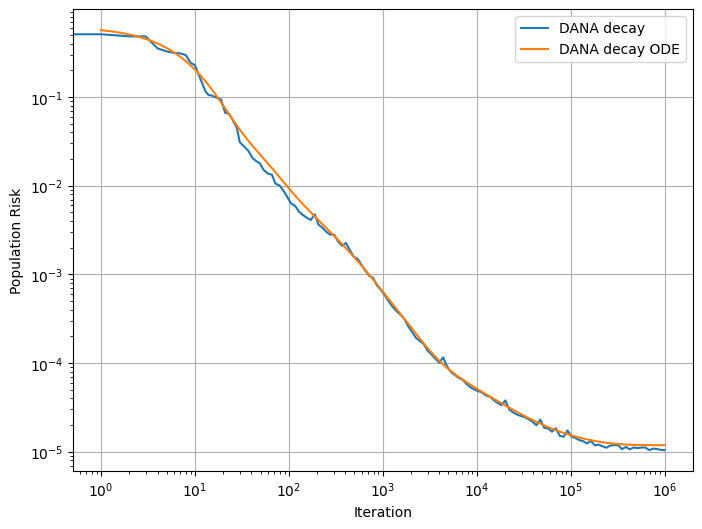

In [207]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA decay ODE')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

In [171]:
def lsq_streaming_optax_simple_noscan(
        key, 
        data_oracle,
        batch_size,
        steps,
        optimizer,
        init,
        loss_oracle
):
    #d=init.shape[0]
    tx=optimizer
    params = init
    opt_state = tx.init(params)
    state = (params, opt_state)

    def batch_mse(params, embeddings, y):
        y_pred = embeddings@params
        return jnp.mean(optax.l2_loss(y_pred, y))

    def train_step(state,key):
        params, opt_state = state
        (embeddings, y) = data_oracle(key, batch_size)
        loss_fn = lambda params : batch_mse(params, embeddings, y)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    keyz = random.split(key, steps)
    losses=[]
    for i, key in enumerate(tqdm(keyz)):
        state, loss = train_step(state, key)
        pop_loss = loss_oracle(state[0])
        losses.append(pop_loss)

    return jnp.arange(1,steps+1), losses

In [173]:
def lsq_streaming_optax_simple(
        key,
        data_oracle,
        batch_size,
        steps,
        optimizer,
        init,
        loss_oracle
):
    """Trains a linear model using stochastic gradient descent with a simple learning rate schedule.
    
    Args:
        key: JAX PRNGKey for random number generation
        data_oracle: Function that generates batches of (embeddings, labels) training data
        batch_size: Number of samples per batch
        steps: Total number of optimization steps
        learning_rate: Fixed learning rate for SGD
        init: Initial parameter vector
        loss_oracle: Function that computes population loss given parameters
    
    Returns:
        tuple: (timestamps, losses) where timestamps are the iteration numbers at which
        losses were recorded and losses are the corresponding population loss values
    """
    tx = optimizer
    params = init
    opt_state = tx.init(params)
    state = (params, opt_state)

    def batch_mse(params, embeddings, y):
        y_pred = embeddings@params
        return jnp.mean(optax.l2_loss(y_pred, y))

    def train_step(state,key):
        params, opt_state = state
        (embeddings, y) = data_oracle(key, batch_size)
        loss_fn = lambda params : batch_mse(params, embeddings, y)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        #return (params, opt_state), loss
        return (params, opt_state), None
    

    # This generates an exponentially spaced sequence of times at which we record the loss.
    # This is to ensure that we are recording the loss at a reasonable frequency.
    # We start at 0 and go up to the total number of steps.
    # We then add the number of steps to the list.
    # We then take the unique values and sort them.
    # This gives us the times at which we record the loss.
    
    losses=[]
    losstimes = jnp.unique(jnp.concatenate(
        [jnp.array([0]),
        jnp.int32(
            1.1**jnp.arange(1,jnp.ceil(jnp.log(steps)/jnp.log(1.1)))
        ),
        jnp.array([steps])]
    ))

    losstime_steps = losstimes[1:]-losstimes[:-1]
    losses.append(loss_oracle(init))
    for increment in tqdm(losstime_steps):
        key, subkey = random.split(key)
        keyz = random.split(subkey, increment)
        state, _ = jax.lax.scan(train_step, state, keyz)
        pop_loss = loss_oracle(state[0])
        losses.append(pop_loss)

    return losstimes, losses
    